In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import torch
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_8DLorenz.recursive_LSTM_PostMeanScore_8DLorenz_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape[0] == y_pred.shape[0])
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [3]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


In [4]:
def get_drift_files(config):
    ts_type = f"{config.ndims}DLorenz"
    include =  (f"_{1}NDT_{config.loss_factor}LFac_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    driftoostrack_true_files = []
    driftoostrack_local_files = []
    for file in os.listdir(root_dir):
        if "LSTM" in file and ts_type in file and include in file:
            if "OOSDriftTrack" in file and "true" in file:
                driftoostrack_true_files.append(root_dir+file)
            elif "OOSDriftTrack" in file and "local" in file:
                driftoostrack_local_files.append(root_dir+file)
    assert len(driftoostrack_true_files)>0, "No oos drift track files found"
    assert len(driftoostrack_local_files)>0, "No oos drift track files found"
    assert(len(driftoostrack_true_files) == len(driftoostrack_true_files))
    def extract_bw_drift_track_number(s):
        match = s.split("Nep_")[0].split("_")[-1]
        return int(match)
    driftoostrack_true_files = sorted(driftoostrack_true_files, key=extract_bw_drift_track_number)
    driftoostrack_local_files = sorted(driftoostrack_local_files, key=extract_bw_drift_track_number)
    Nepochs_track = [extract_bw_drift_track_number(f) for f in driftoostrack_true_files]
    return driftoostrack_true_files[:-8], driftoostrack_local_files[:-8], Nepochs_track[:-8]

In [8]:
drift_true_files, drift_local_files, Nepochs = get_drift_files(config)
len(Nepochs)

3378

In [10]:
drift_track_rmses = {}
for f_idx in tqdm(range(len(Nepochs))):
    Nepoch = Nepochs[f_idx]
    true = drift_true_files[f_idx]
    local = drift_local_files[f_idx]
    try:
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        drift_track_rmses.update({Nepoch:total_local_errors[-1]})
    except FileNotFoundError as e:
        print(e)
        continue
drift_track_rmses

100%|█████████▉| 3377/3378 [03:50<00:00, 14.68it/s]


IndexError: list index out of range

8028 6776
(3377,) (3377,)


0.8904071956074332

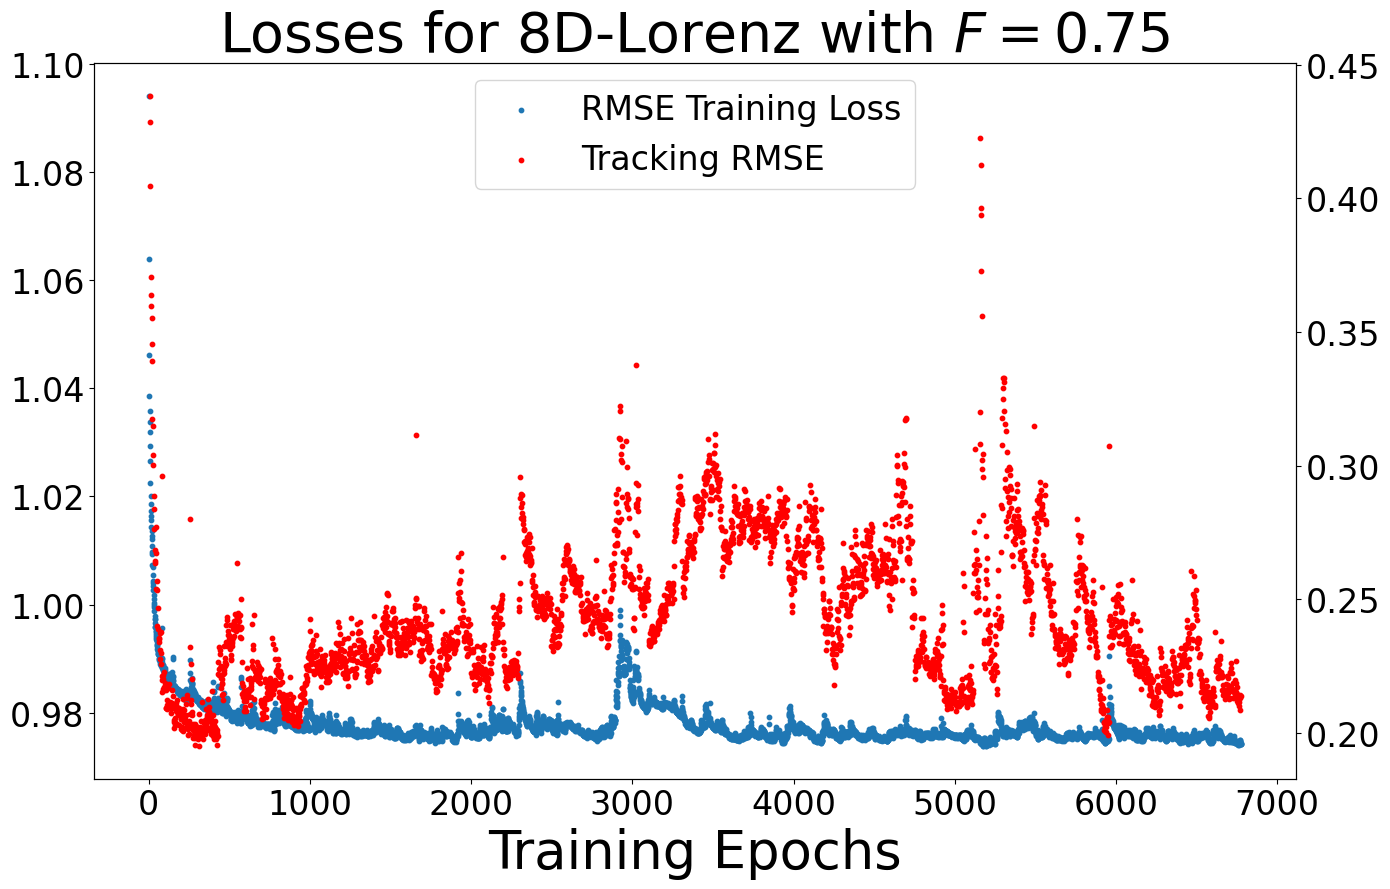

In [31]:
with open(config.scoreNet_trained_path.replace("/trained_models/", "/training_losses/") + "_loss", 'rb') as f:
        losses = np.sqrt(np.array(pickle.load(f)).astype(float))
print(len(losses), Nepochs[-1])
losses = losses[:Nepochs[-1]+1]
start_idx = 2
fig, ax = plt.subplots(figsize=(14,9))
sc1 = ax.scatter(np.arange(start_idx, losses.shape[0]), losses[start_idx:], s=10, label="RMSE Training Loss")
ax.tick_params(axis="both",labelsize=24)
ax2 = ax.twinx()
track_epochs = np.array(Nepochs[:len(list(drift_track_rmses.values()))])
track_rmses = np.array(list(drift_track_rmses.values()))[:len(track_epochs)+1]
#track_rmses /= track_rmses[0]
print(track_epochs.shape, track_rmses.shape)
sc2 = ax2.scatter(track_epochs, track_rmses, s=10, color="red",label="Tracking RMSE")
ax.set_xlabel("Training Epochs", fontsize=38)
ax.set_title(r"Losses for 8D-Lorenz with $F = 0.75$", fontsize=40)
ax.tick_params(axis="both",labelsize=24)
ax2.tick_params(axis="both",labelsize=24)
#ax.set_yscale("log")
plt.tight_layout()
handles = [sc1, sc2]
labels = [h.get_label() for h in handles]
# Add a single legend on ax1
ax.legend(handles, labels, loc="upper center", fontsize=24)
plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/f8DLnz_Losses_PM_LSTM_{round(config.forcing_const,3)}FConst").replace(".", "")+".png")
losses[-1]/losses[start_idx]

  0%|          | 0/3378 [00:00<?, ?it/s]

0.1949732937810785 inf


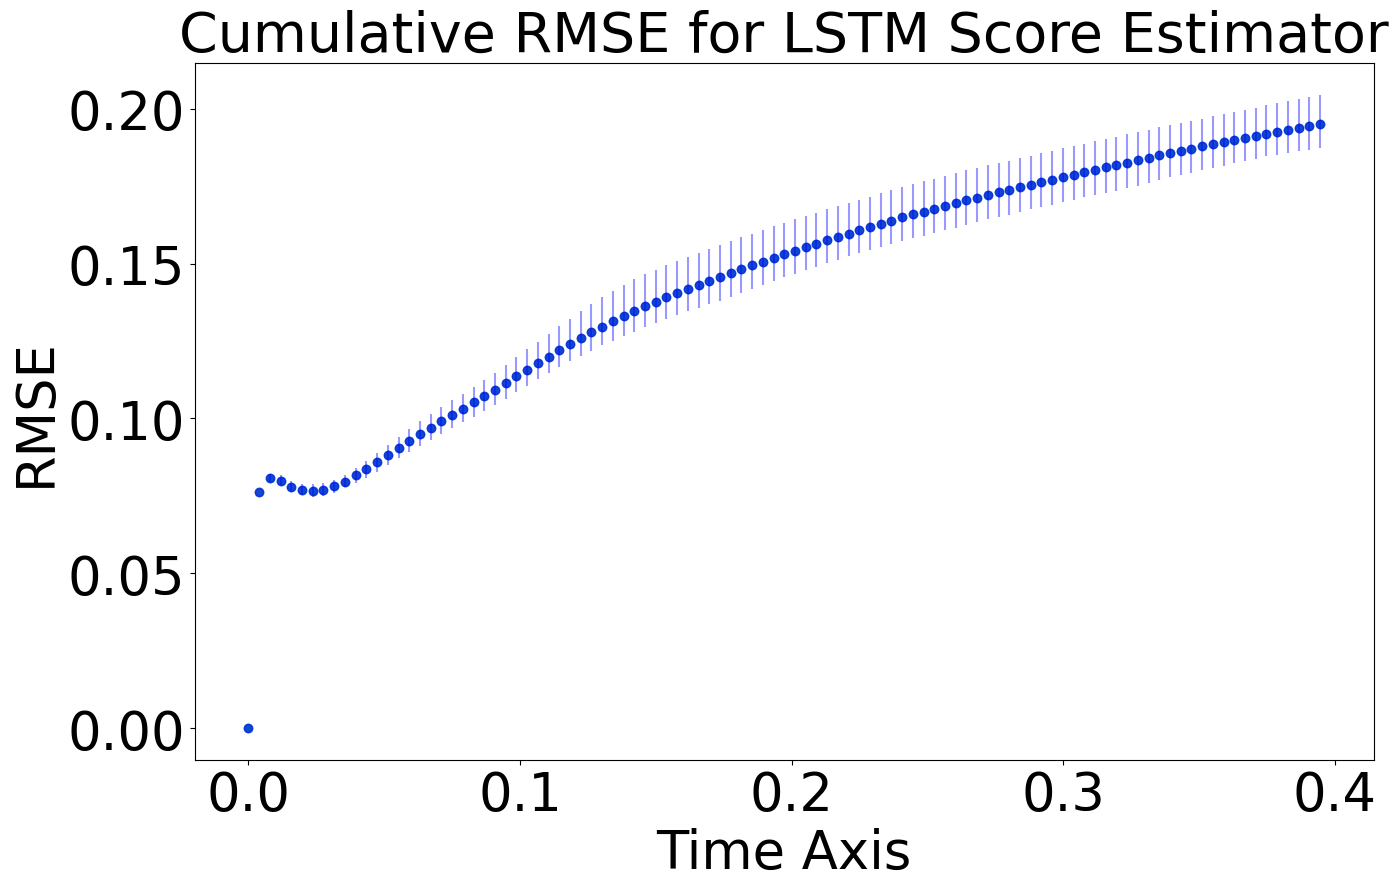

100%|█████████▉| 3377/3378 [00:00<00:00, 5659.97it/s]

Final time cumulative RMSE local-time error 0.1949732937810785 with final IQR (0.18732120371736066, 0.20454675058790817) at Nepoch 310 for 0.75FConst



IndexError: list index out of range

In [34]:
curr_rmse = np.inf
toSave = True
for f_idx in tqdm(range(len(Nepochs))):
    Nepoch = Nepochs[f_idx]
    true = drift_true_files[f_idx]
    local = drift_local_files[f_idx]
    try:
        num_diff_times = 1
        save_path = (
                project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_{config.ndims}DLorenz_OOSDriftTrack_{Nepoch}Nep_tl{config.tdata_mult}data_{config.t0}t0_{config.deltaT:.3e}dT_{num_diff_times}NDT_{config.loss_factor}LFac_{round(config.forcing_const,3)}FConst").replace(
            ".", "")
        all_true_states = np.load(true)/np.sqrt(config.deltaT)
        all_local_states= np.load(local)/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], curr_rmse)
        if total_local_errors[-1] < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/f8DLnz_OOSDriftTrack_{Nepoch}Nep_PM_LSTM_{config.forcing_const}FConst").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with final IQR {(total_local_errors_minq[-1], total_local_errors_maxq[-1])} at Nepoch {Nepoch} for {config.forcing_const}FConst\n")
    except FileNotFoundError as e:
        continue